# Training 


In [2]:
import numpy as np
import pandas as pd
import os
import sys  
sys.path.append(".")
import data_cleaning

# deep learning
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
# produce vector inline graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

/opt/anaconda3/lib/python3.7/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/opt/anaconda3/lib/python3.7/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <3224DED3-FCE0-3B10-9D68-9EC019B2AFEC> /opt/anaconda3/lib/python3.7/site-packages/torchvision/image.so
  Expected in:     <7EC12623-0CF1-3739-8CBB-242EFC29E2B3> /opt/anaconda3/lib/python3.7/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


# Setup

In [3]:
# Check version of Pytorch
print(torch. __version__)

1.13.1


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# Data


In [5]:
## training data images

# choose between big (different angles, 13gb) or small image dataset (only frontal views, 5gb)
all_cars = True # precicate for big or small car-dataset
if all_cars:
    image_dir = "../data/all_cars" # + brand name + year + image_name 
else:
    image_dir = "../data/confirmed_fronts" # + brand name + year + image_name


##  Training data tabular
# data_df = data_cleaning.create_feature_df()
data = pd.read_csv("../data/tables/features.csv")
data

,Brand_Name,Brand_ID,Model_Name,Model_ID,Bodytype,Launch_Year,Color,Advertiser_ID,Image_ID,file_path
0,Abarth,2,124 Spider,2_1,Convertible,2017,Blue,1,image_1.jpg,Abarth$$124 Spider$$2017$$Blue$$2_1$$1$$image_...
1,Abarth,2,124 Spider,2_1,Convertible,2017,Blue,10,image_11.jpg,Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...
2,Abarth,2,124 Spider,2_1,Convertible,2017,Blue,10,image_16.jpg,Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...
3,Abarth,2,124 Spider,2_1,Convertible,2017,Blue,10,image_18.jpg,Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...
4,Abarth,2,124 Spider,2_1,Convertible,2017,Blue,10,image_2.jpg,Abarth$$124 Spider$$2017$$Blue$$2_1$$10$$image...
...,...,...,...,...,...,...,...,...,...,...
271318,Zenos,99,E10,99_1,Convertible,2016,Grey,3,image_7.jpg,Zenos$$E10$$2016$$Grey$$99_1$$3$$image_7.jpg
271319,Zenos,99,E10,99_1,Convertible,2016,Red,1,image_0.jpg,Zenos$$E10$$2016$$Red$$99_1$$1$$image_0.jpg
271320,Zenos,99,E10,99_1,Convertible,2016,Red,1,image_3.jpg,Zenos$$E10$$2016$$Red$$99_1$$1$$image_3.jpg
271321,Zenos,99,E10,99_1,Convertible,2016,Red,1,image_4.jpg,Zenos$$E10$$2016$$Red$$99_1$$1$$image_4.jpg


## training data (70%), validation set (10%), test data (20%)

In [6]:
seed = 384
rng = np.random.default_rng(seed)
# TODO: stratify test, train, val by classes (e.g., brand, year, etc.)
# we need to make sure that images of a car model (specified by Model_ID and launch_year) are not distributed over training, validation and test dataset when splitting. 

# subset dataframe by car model (specified by launch_year and model_id) and find unique combinations and then sample accordingly
unique_cars = data[["Model_ID", "Launch_Year"]].drop_duplicates()

# draw random indices according to splits from unique cars
rand_nums = rng.uniform(size = len(unique_cars))
msk_train = rand_nums < 0.7 # draws random numbers from uniform distribution, 70%


msk_val_test = ~msk_train # complement

# subset unique cars by indices
msk_val = rand_nums >= 0.9 # 10%

#msk_test = ~msk_val & ~msk_train #  20%
msk_test = (rand_nums > 0.7) & (rand_nums < 0.9)

# test if all datasets only contain unique cars
assert not (np.any(msk_val_test & msk_train))
assert not (np.any(msk_val & msk_test))


# slice unique cars with datamasks 
train_cars_df = unique_cars[msk_train]
test_cars_df = unique_cars[msk_test]
val_cars_df = unique_cars[msk_val]

# check unique cars len is equal to the sum of its sub dfs
assert len(val_cars_df) + len(test_cars_df) + len(train_cars_df) == len(unique_cars)

# complement unique cars per dataset with corresponding rows (launchyear, model id) from features df
# train_df = data.loc[((data['Launch_Year'].isin(train_cars_df['Launch_Year'])) & data['Model_ID'].isin(train_cars_df['Model_ID']))]

# test_df = data.loc[((data['Launch_Year'].isin(test_cars_df['Launch_Year'])) & data['Model_ID'].isin(test_cars_df['Model_ID']))]

# val_df = data.loc[((data['Launch_Year'].isin(val_cars_df['Launch_Year'])) & data['Model_ID'].isin(val_cars_df['Model_ID']))]


#df[df[['a', 'b']].apply(tuple, axis=1).isin([(1,2), (4,3)])]
train_df = data[data[['Launch_Year', 'Model_ID']].apply(tuple, axis=1).isin(train_cars_df[['Launch_Year', 'Model_ID']].apply(tuple, axis=1))]

val_df = data[data[['Launch_Year', 'Model_ID']].apply(tuple, axis=1).isin(val_cars_df[['Launch_Year', 'Model_ID']].apply(tuple, axis=1))]

test_df = data[data[['Launch_Year', 'Model_ID']].apply(tuple, axis=1).isin(test_cars_df[['Launch_Year', 'Model_ID']].apply(tuple, axis=1))]

# check if len of entire data set is equal to sum of test, train and val dataset
assert len(test_df) + len(train_df) + len(val_df) == len(data)

In [7]:
data["Launch_Year"].max()

2019

### Custom Dataset class

In [8]:
from typing import Callable
from skimage import io

def year2label_fn(year:int, min_year:int=1990, max_year:int=2019, year_bucket_size:int= 2) -> int:
    """
    converts year to label (int)
    in ranges determined through year_bucket_size
    """
    if year < min_year:
        raise ValueError(f"Year {year} smaller than the minimum year {min_year}.")
    if year > max_year:
        raise ValueError(f"Year {year} bigger than the maximum year {max_year}.")
    if (year <0)| (min_year <0)| (max_year <0) | (year_bucket_size <0):
        raise ValueError("One of the arguments is negative and should be >= 0.")

    year_range = max_year - min_year + 1
    num_buckets = year_range // year_bucket_size
    year_ratio = (year - min_year) / year_range
    label = int(np.floor( year_ratio * num_buckets))

    assert label >= 0
    return label



def bodytype2label_fn(bodytype:str, possible_bodytypes:list=['Convertible', 'Coupe', 'Hatchback', 'MPV', 'Saloon', 'Estate', 'Van',
       'SUV', 'Minibus', 'Pickup',
       'Manual', 'Tipper', 'Camper', 'Chassis Cab',
       'Limousine']) -> int:
    """
    converts body-type to label
    """
    # if bodytype contains "van": then bodytype = van
    # all van bodytypes: 'Combi Van', 'Panel Van', 'Window Van', 'Car Derived Van'
    if "Van" in bodytype:
        bodytype = "Van"

    
    # create dictionary key:bodytype, value: label
    # create labels in range of bodytype list length
    labels_list = np.arange(len(possible_bodytypes)).tolist()
    bodytype2label_dict = dict(zip(possible_bodytypes, labels_list))
    return  bodytype2label_dict[bodytype]



class CarDataset(torch.utils.data.Dataset):
    """
    DVM-CAR dataset (A Large-Scale Automotive Dataset for Visual Marketing Research and Applications)
    """

    def __init__(
        self, 
        features:pd.DataFrame,
        year2label_fn:Callable = year2label_fn, 
        bodytype2label_fn:Callable = bodytype2label_fn,
        transform:Callable = None,
        year_bucket_size:int = 2,
        img_root_dir:str = "../data/all_cars", 
    ):
        self.features = features
        self.bodytype2label_fn = bodytype2label_fn
        self.year2label_fn = year2label_fn
        self.img_root_dir = img_root_dir
        self.transform = transform
        self.year_bucket_size = year_bucket_size
        



    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # access row indicated by idx and extrac values to be returned except for image
        row_of_interest = self.features.iloc[idx] 
        bodytype = row_of_interest["Bodytype"]
        launch_year = row_of_interest["Launch_Year"]
        model_id = row_of_interest["Model_ID"]

         # to get image, concatenate root-dir and file-path in features df
         # different image organizatin depending on all cars datset or small datset
        if all_cars:
            #print("all cars")
            self.img_root_dir =  "../data/all_cars"
            image_file_path = self.img_root_dir  + "/"+ row_of_interest["Brand_Name"] + "/"+ str(row_of_interest["Model_Name"])+"/"+ str(row_of_interest["Launch_Year"])+"/"+str(row_of_interest["Color"])+"/" + row_of_interest["file_path"]
        else:
            self.img_root_dir =  "../data/confirmed_fronts"
            image_file_path = self.img_root_dir  + "/"+ row_of_interest["Brand_Name"] + "/"+ str(row_of_interest["Launch_Year"])+"/" + row_of_interest["file_path"]

        # load image as tensor
        image = io.imread(image_file_path)

        # transform image
        if self.transform is not None:
            image = self.transform(image)


        return image, bodytype, model_id, launch_year, self.bodytype2label_fn(bodytype), self.year2label_fn(year=launch_year, year_bucket_size = self.year_bucket_size)
    


In [9]:
car_dataset = CarDataset(data)

In [15]:
test_datapoint = car_dataset[11] # idx 10300 exists in small image dataset

all cars


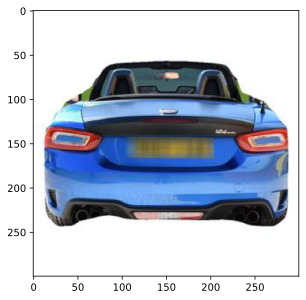

In [16]:
plt.imshow(test_datapoint[0])

In [18]:
year2label_fn(2000, year_bucket_size=10)

1

In [19]:
bodytype2label_fn("Car Derived Van")

6

### Data augmentation and transformation:

In [20]:
# resize images to 224x224 (imageNet size)
# normalize image: 
# mean =[0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225] (ImgNet mean and std)
#optional: randomResizedCrop, etc.

# Data agumentation and normalization for training

data_transforms = {
    "train":transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((224,224)),
            transforms.ColorJitter(),
            transforms.RandomInvert(),
            transforms.RandomPerspective(distortion_scale=0.1, p=0.1),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225]),
        ]
    ),
    "val":transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Resize((224,224)),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225]),

        ]
    )
}

In [21]:
seed_t = 123
torch.manual_seed(seed_t)

# load dataset
# create torch.dataset --> specify transform arguement accordingly

train_set = CarDataset(features=train_df, transform=data_transforms["train"])
test_set = CarDataset(features=test_df, transform=data_transforms["val"])
val_set = CarDataset(features=val_df, transform=data_transforms["val"])


# data loaders for all train, test, val datasets
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(test_set))
val_loader = torch.utils.data.DataLoader(val_set, batch_size=len(val_set))

all cars


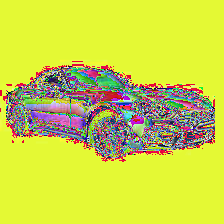

In [23]:
test_point_transf = train_set[12]
post_transf = torchvision.transforms.functional.to_pil_image(test_point_transf[0])
post_transf

In [24]:
test_point_transf[0].shape

torch.Size([3, 224, 224])

## Model

## loss function

## optimizer

##  training


##  evaluation